# Breast cancer case

In [34]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split, StratifiedKFold


import matplotlib.pyplot as plt

from _crossvalidation import crossvalidation_as_framework

### Load and prep data

In [2]:
data = pd.read_csv('../data/brca_data_w_meta.csv')

In [3]:
# Define the target variable
target = "vital.status"

In [4]:
stypes = {}
for f in data.columns:
    if data[f].dtype == 'object':
        stypes[f] = 'c'

### 2 feature models

In [23]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     criterion='bic',
                                     max_complexity = 3)

KeyboardInterrupt: 

In [12]:
results.groupby("fold").first().roc_auc_val.mean(), results.roc_auc_val.mean()

(0.6183480214152156, 0.6313666034560834)

In [17]:
for model in results.groupby("fold").first().model_structure:
    print(model)

logreg((cnCLDN19 + muGPR98)*(rsCIDEC*rsPIK3C2G + rsSLC7A4))
logreg((rsALOX15 + rsIGSF1)*(rsALOX15B + rsAPOB + rsTRPV6))
logreg(tanh(rsKLK8*(muPDZD2 + rsTMPRSS4 + exp(-cnSLC13A2**2 - rsLGALS12**2))))
logreg(cnTGFBR3*rsPOF1B + rsFGFBP1*(rsSLC6A15 + tanh(rsCIDEC)))
logreg(tanh(cnABCC6 + rsMAGEA3 + rsSLC28A3*(rsCACNG4 + rsGLYAT)))


### Larger models (default options)

In [18]:
results100 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     criterion='bic')

In [22]:
results.groupby("fold").first().roc_auc_val.mean(), results.roc_auc_val.mean()

(0.6183480214152156, 0.6313666034560834)

In [19]:
for model in results100.groupby("fold").first().model_structure:
    print(model)

logreg(rsPTCHD1*(cnADAMTS16 + muDMD + rsFABP4 + rsSOX2))
logreg(rsAPOB*(cnPRODH*(cnCOL14A1 + ppPI3K.p110.alpha) + rsTAT))
logreg(cnCLCA2 + rsSLC13A2*(cnSLC30A8 + rsAPOB + rsPAX7))
logreg(rsTCN1*(ppp27 + rsDEFB132*rsPTPRZ1 + rsSOX2))
logreg(cnTNFRSF11B + ppMSH6**2 + rsCYP4Z2P + rsPCOLCE2 + rsPLA2G2D)


#### Exploration of best models

In [35]:
ql = feyn.connect_qlattice()
ql.reset(random_seed=42)


In [42]:
best_models_qstrings = ['"rs_PTCHD1"*("cn_ADAMTS16" + "mu_DMD" + "rs_FABP4" + "rs_SOX2")',
                        '"rs_APOB"*("cn_PRODH"*("cn_COL14A1" + "pp_PI3K.p110.alpha") + "rs_TAT")',
                        '"cn_CLCA2" + "rs_SLC13A2"*("cn_SLC30A8" + "rs_APOB" + "rs_PAX7")',
                        '"rs_TCN1"*("pp_p27" + "rs_DEFB132"*"rs_PTPRZ1" + "rs_SOX2")',
                        '"cn_TNFRSF11B" + squared("pp_MSH6") + "rs_CYP4Z2P" + "rs_PCOLCE2" + "rs_PLA2G2D"']
n_folds = 5
random_state = 42
models_trained = []
train_list = []
val_list = []

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
for i, (train, val) in enumerate(kfold_test.split(data, data[target])):
        train, val = data.iloc[train], data.iloc[val]
        train_list.append(train)
        val_list.append(val)
        
        sample_weights = np.where(train[target] == 1,
                                      np.sum(train[target] == 0) / sum(train[target]), 1)
        
        model = ql.auto_run(train, output_name=target, n_epochs=10, kind = "classification",
                             query_string=best_models_qstrings[i], sample_weights=sample_weights, stypes=stypes)[0]
        models_trained.append(model)
        

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="264.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 981 264.0" width="981" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="711" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="601" y="50.0"><title>vital.status
logistic:
w=0.9331
bias=-0.3493</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="646.0" y="71.5">vital.st..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="689" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="603" y="59.0">out</text><line stroke="#1E1E1E" x1="571" x2="601" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="481" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="59.0">1</text><line stroke="#1E1E1E" x1="451" x2="481" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="451" x2="481" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="20.0"><title>rs_APOB
linear:
scale=0.149502
scale offset=2.325769
w=-2.074715
bias=0.3888</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="41.5">rs_APOB</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="101.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="89.0">3</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="106.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="20.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">4</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="46.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>cn_PRODH
linear:
scale=0.500000
scale offset=-0.331560
w=1.024015
bias=-0.7856</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">cn_PRODH</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-fam
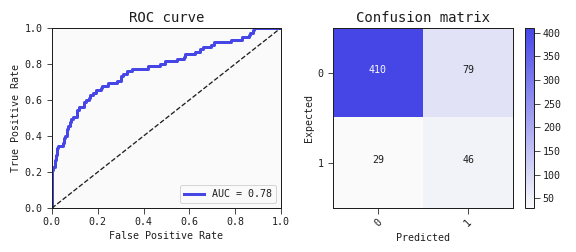
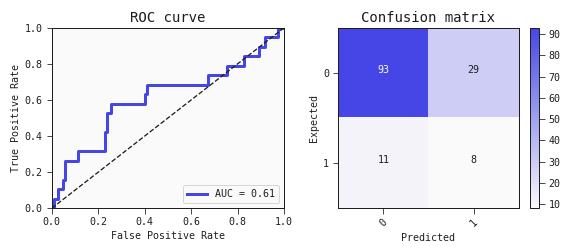

In [45]:
models_trained[1].plot(train_list[1], val_list[1])

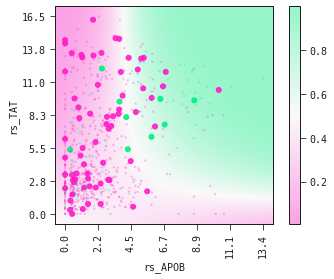

In [73]:
models_trained[1].plot_response_2d(data, 
                                   {"cn_COL14A1":0
                                    , "cn_PRODH":data["cn_PRODH"].mean(), "pp_PI3K.p110.alpha":data["pp_PI3K.p110.alpha"].mean()})

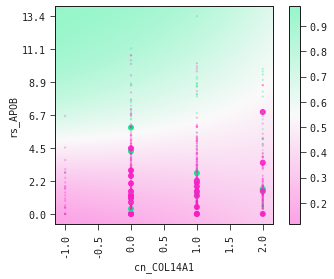

In [69]:
models_trained[1].plot_response_2d(data, 
                                   {"rs_TAT":data["rs_TAT"].mean(), "cn_PRODH":data["cn_PRODH"].mean(), "pp_PI3K.p110.alpha":data["pp_PI3K.p110.alpha"].mean()})

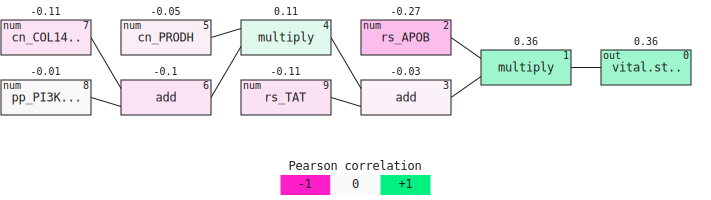

In [67]:
models_trained[1].plot_signal(data)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="324.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 981 324.0" width="981" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="215.0" width="711" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="601" y="80.0"><title>vital.status
logistic:
w=-0.9166
bias=-0.7564</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="646.0" y="101.5">vital.st..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="689" y="89.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="603" y="89.0">out</text><line stroke="#1E1E1E" x1="571" x2="601" y1="97.5" y2="97.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="481" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="101.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="89.0">1</text><line stroke="#1E1E1E" x1="451" x2="481" y1="67.5" y2="88.5" /><line stroke="#1E1E1E" x1="451" x2="481" y1="127.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="50.0"><title>cn_TNFRSF11B
linear:
scale=0.500000
scale offset=0.778369
w=-1.644682
bias=-1.5969</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">cn_TNFRS..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="59.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="110.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="131.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="119.0">3</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="118.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="127.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>squared</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">squared</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">4</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="67.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>pp_MSH6
linear:
scale=0.518280
scale offset=0.019021
w=-1.642344
bias=0.3252</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">pp_MSH6</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="110.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" 
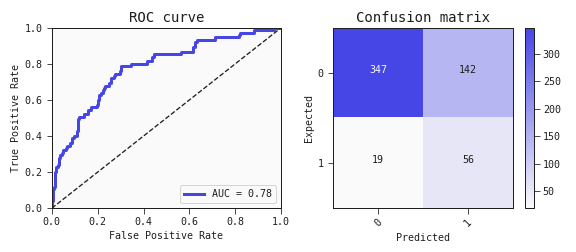
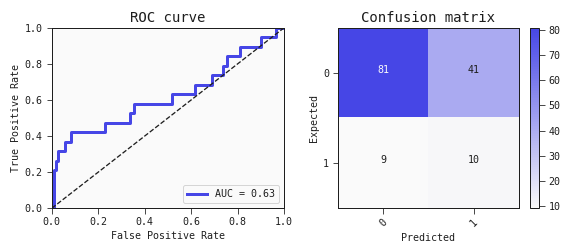

In [47]:
models_trained[4].plot(train_list[4], val_list[4])

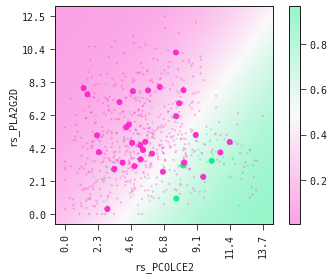

In [49]:
models_trained[4].plot_response_2d(data, 
                                   {"cn_TNFRSF11B":0, "pp_MSH6":data["pp_MSH6"].mean(), 
                                    "rs_CYP4Z2P":data["rs_CYP4Z2P"].mean()})

In [63]:
for train, val in zip(train_list, val_list):
    print("train: ", train["patient.clinical.cqcf.histological.type"].value_counts().values[0]/train["patient.clinical.cqcf.histological.type"].value_counts().values[1])
    print("val: ",  val["patient.clinical.cqcf.histological.type"].value_counts().values[0]/val["patient.clinical.cqcf.histological.type"].value_counts().values[1])

train:  4.475728155339806
val:  4.222222222222222
train:  4.371428571428571
val:  4.64
train:  4.755102040816326
val:  3.40625
train:  4.222222222222222
val:  5.409090909090909
train:  4.320754716981132
val:  4.875


### Comparison with random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
list_auc = []
n_folds = 5
random_state = 42
df = pd.get_dummies(data)

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)


for i, (train, val) in enumerate(kfold_test.split(df, df[target])):
    train, val = df.iloc[train], df.iloc[val]
    params = {'bootstrap': True,
     'ccp_alpha': 0.0,
     'class_weight': 'balanced',
     'max_depth': 4,
     'max_features': 'auto',
     'max_leaf_nodes': None,
     'max_samples': None,
     'min_impurity_decrease': 0.0,
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'min_weight_fraction_leaf': 0.0,
     'n_estimators': 100,
     'random_state': 42
    }

    rf = RandomForestClassifier(**params)
    rf.fit(train.drop(columns=target), train[target])
    preds = rf.predict(val.drop(columns=target))

    list_auc.append(roc_auc_score(val[target], preds))